In [1]:
# Copyright 2017 Junghoon Lee
#   jhoon.chris@gmail.com

In [1]:
import pandas_datareader as pdr
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
from pandas import Series, DataFrame, Panel
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from sp_ml import SpMl

In [8]:
class SpLinearReg(SpMl):
    'stock prediction by linear regression'
    
    def __init__(self):
        pass
        
    def preprocess_fetures(self):
        #print self.ivv.head()
        self.nm_ivv = self.ivv.copy(deep=True)
        self.nm_ivv['Adj Close'] = self.nm_ivv['Adj Close']/self.nm_ivv['Adj Close'][0]
        self.nm_ivv['Volume'] = self.nm_ivv['Volume']/self.nm_ivv['Volume'].mean()
        self.nm_ivv['Open'] = (self.nm_ivv['Close']-self.nm_ivv['Open'])/self.nm_ivv['Open']
        self.nm_ivv['High'] = (self.nm_ivv['High']-self.nm_ivv['Low'])/self.nm_ivv['Low']
        self.nm_ivv = self.nm_ivv.rename(columns = {'Open':'Change'})
        self.nm_ivv = self.nm_ivv.rename(columns = {'High':'Maxofday'})
        #print self.nm_ivv.head()

        #print self.gld.head()
        self.nm_gld = self.gld.copy(deep=True)
        self.nm_gld['Adj Close'] = self.nm_gld['Adj Close']/self.nm_gld['Adj Close'][0]
        self.nm_gld['Volume'] = self.nm_gld['Volume']/self.nm_gld['Volume'].mean()
        print self.nm_gld.head()

        self.prices = self.nm_ivv['Adj Close']
        self.features = self.nm_ivv.drop(['Close', 'Low'], axis = 1)

        # Rolling Mean 10 days
        self.rm10_ivv = pd.rolling_mean(self.nm_ivv['Adj Close'], window=10)
        self.rm10_ivv_ = pd.DataFrame(self.rm10_ivv)
        self.rm10_ivv_ = self.rm10_ivv_.rename(columns = {'Adj Close':'RM10'})

        # Rolling Mean 20 days
        self.rm20_ivv = pd.rolling_mean(self.nm_ivv['Adj Close'], window=20)
        self.rm20_ivv_ = pd.DataFrame(self.rm20_ivv)
        self.rm20_ivv_ = self.rm20_ivv_.rename(columns = {'Adj Close':'RM20'})
        #print self.rm20_ivv_.tail()

        # Rolling Mean 40 days
        self.rm40_ivv = pd.rolling_mean(self.nm_ivv['Adj Close'], window=40)
        self.rm40_ivv_ = pd.DataFrame(self.rm40_ivv)
        self.rm40_ivv_ = self.rm40_ivv_.rename(columns = {'Adj Close':'RM40'})

        #print gld.head()
        self.nm_gld = self.nm_gld.drop(['Open', 'High', 'Close', 'Low', 'Volume'], axis = 1)
        self.nm_gld = self.nm_gld.rename(columns = {'Adj Close':'GLD'})
        print self.nm_gld.head()
        print self.rm10_ivv_.head()
        #print "gold.dtypes", gold.dtypes

        self.features = self.features.join(self.nm_gld['GLD'], how='inner')
        self.features = self.features.join(self.rm10_ivv_, how='inner')
        self.features = self.features.join(self.rm20_ivv_, how='inner')
        self.features = self.features.join(self.rm40_ivv_, how='inner')
        print self.features.head()
        
        return

    
    def display_fetures(self):
        self.ivv[['Close','Adj Close', 'Open', 'High', 'Low']].plot(title='IVV price')
        plt.show()

        self.nm_ivv['Volume'].plot(title='nomalized IVV Volume')
        plt.show()

        self.gld[['Close','Adj Close', 'Open', 'High', 'Low']].plot(title='GLD price')
        plt.show()

        self.features[['Adj Close', 'RM20', 'RM40']].plot(title='nomalized IVV price, 20-days, 40-days mean')
        plt.show()
        return


    def do_regression(self):
        X_train = self.features[65:-50]
        y_train = self.prices[70:-45]
        X_test = self.features[-50:-5]
        y_test = self.prices[-45:]

        # Show the results of the split
        print "Training set has {} samples.".format(X_train.shape[0])
        print "Testing set has {} samples.".format(X_test.shape[0])

        print X_train
        #print X_train[:,1]
        print y_train

        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        
        LR_result = pd.DataFrame(y_test)
        #print LR_result 
        #print y_pred
        #print y_test

        LR_result = LR_result.assign(Prediction = y_pred)
        # print LR_result
        LR_result = LR_result.rename(columns = {'Adj Close':'Real price'})
        LR_result[['Real price','Prediction']].plot(title='Linear Regression tes result')
        plt.show()

        # The coefficients
        print('Coefficients: \n', regr.coef_)
        # The mean squared error
        print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(y_test, y_pred))
        
        return
    
    
    def predict_nextweek(self):
        # Predict future 1-week
        X_train = self.features[65:-5]
        y_train = self.prices[70:]
        X_future = self.features[-5:]

        regr = linear_model.LinearRegression()        
        regr.fit(X_train.values, y_train.values)

        # Make predictions using the testing set
        y_future = regr.predict(X_future)

        start_predict_day = now+datetime.timedelta(1)
        end_predict_day = now+datetime.timedelta(5)
        start_predict_day = start_predict_day.strftime("%Y-%m-%d")
        end_predict_day = end_predict_day.strftime("%Y-%m-%d")

        days = pd.date_range(start_predict_day, end_predict_day, freq='D')

        df = pd.DataFrame({'Date': days, 'Prediction': y_future})
        df = df.set_index('Date')
        df['Prediction'] = df['Prediction'] * self.ivv['Adj Close'][0]
        print df 

        real_prices = self.prices[-10:] * self.ivv['Adj Close'][0]
        ax = real_prices.plot()
        df['Prediction'].plot(title='Linear Regression stock price forecasting', ax = ax)
        plt.show()
        return
    

2017-12-14
loading :  IVV from :  2016-01-01  to :  2017-12-14
loading :  GLD from :  2016-01-01  to :  2017-12-14
                  Open        High         Low       Close  Adj Close  \
Date                                                                    
2016-01-04  103.129997  103.669998  102.489998  102.889999   1.000000   
2016-01-05  103.129997  103.459999  102.930000  103.180000   1.002819   
2016-01-06  104.370003  104.800003  103.930000  104.669998   1.017300   
2016-01-07  105.830002  106.239998  105.190002  106.150002   1.031684   
2016-01-08  105.480003  105.800003  105.040001  105.680000   1.027116   

              Volume  
Date                  
2016-01-04  0.703401  
2016-01-05  0.382316  
2016-01-06  1.017594  
2016-01-07  1.281238  
2016-01-08  0.838642  
                 GLD
Date                
2016-01-04  1.000000
2016-01-05  1.002819
2016-01-06  1.017300
2016-01-07  1.031684
2016-01-08  1.027116
            RM10
Date            
2016-01-04   NaN
2016-01-05   N

/home/chrisle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/home/chrisle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
/home/chrisle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=40,center=False).mean()


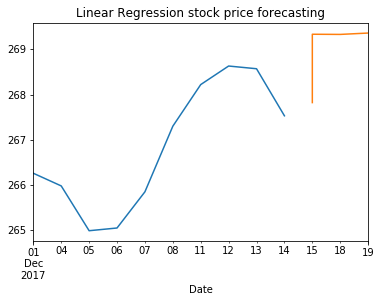

In [9]:
now = datetime.datetime.now()
end_date = now.strftime("%Y-%m-%d")
print end_date

lr_task = SpLinearReg()
lr_task.ivv = lr_task.get_input_feature('IVV', '2016-01-01', end_date)
lr_task.gld = lr_task.get_input_feature('GLD', '2016-01-01', end_date)
#lr_task.ivv = lr_task.get_input_feature_from_file('IVV.csv')
#lr_task.gld = lr_task.get_input_feature_from_file('GLD.csv')

lr_task.preprocess_fetures()

#lr_task.display_fetures()

#lr_task.do_regression()

lr_task.predict_nextweek()